In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [2]:
plt.rcParams.update({
    'font.size': 12,            # Base font size for the plot
    'font.family': 'Times New Roman',  # Font style (IEEE recommends Times New Roman)
    'axes.labelsize': 12,       # Font size for axis labels
    'axes.titlesize': 12,       # Font size for the title
    'legend.fontsize': 10,      # Font size for the legend
    'xtick.labelsize': 10,      # Font size for x-axis tick labels
    'ytick.labelsize': 10,      # Font size for y-axis tick labels
    'lines.linewidth': 1.0,    # Line width for plot lines
    'lines.markersize': 4,     # Marker size
    'figure.figsize': [3.5, 2.5], # Size of the figure (width x height) in inches
    'savefig.dpi': 300,        # Resolution of the output figure
    'legend.loc': 'best',      # Location of the legend
    'legend.frameon': False,   # Remove the box frame around legends
    'pdf.fonttype': 42,        # Embedding fonts in PDF for compatibility
    'ps.fonttype': 42
})

In [31]:
# Load the data
base_path = os.getcwd()
data_output_path = os.path.join(base_path, 'MV_basicload_output')
data_path = os.path.join(base_path, 'MV_basicload_input', 'Zurich_2015-2024.csv')
data = pd.read_csv(data_path)
data = data.iloc[:, :-1]
# delete data begin with 2024, because it is not complete
data = data[data['Timestamp'].str.contains('2024') == False]

# Convert the timestamp to datetime
df=data.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%dT%H:%M:%S%z', errors='coerce',utc=True)
# add one hour to the time
df['Timestamp'] = df['Timestamp'] + pd.DateOffset(hours=1)
df['Month'] = df['Timestamp'].dt.month
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['year'] = df['Timestamp'].dt.year
df['Value_NE5'] = df['Value_NE5']/max(df['Value_NE5'])
monthly_24h_profile = df.groupby(['Month', 'Hour'])['Value_NE5'].mean().reset_index()
monthly_24h_profile['Value_NE5']=monthly_24h_profile['Value_NE5']
monthly_24h_profile_pivot = monthly_24h_profile.pivot_table(
    index=['Hour'],
    columns='Month',
    values='Value_NE5'
)

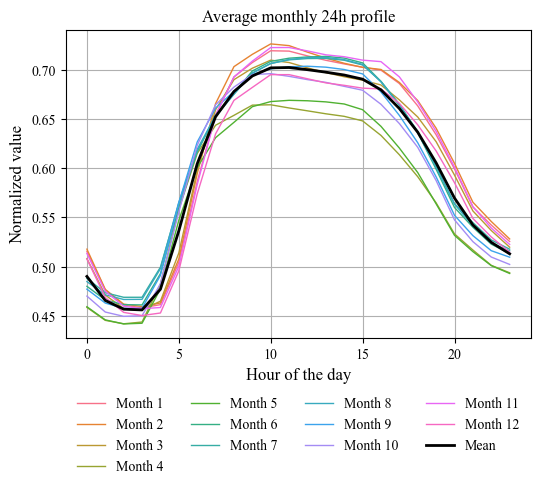

In [32]:
if not os.path.exists(os.path.join(data_output_path, 'Pictures')):
    os.makedirs(os.path.join(data_output_path, 'Pictures'))
colors = sns.color_palette("husl", 12)
fig, ax = plt.subplots(figsize=(6, 4))
# Plot each month with its respective color and label
for i in range(1, 13):
    plt.plot(monthly_24h_profile_pivot[i], label=f'Month {i}', color=colors[i-1])
# Plot the mean with a thicker black line
plt.plot(monthly_24h_profile_pivot.mean(axis=1), label='Mean', color='black', linewidth=2)
# Set labels and title
plt.xlabel('Hour of the day')
plt.ylabel('Normalized value')
plt.title('Average monthly 24h profile')

# Set legend below the plot, with "Mean" after the months
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# Add grid
plt.grid()

# Save the figure with tight layout
plt.savefig(os.path.join(data_output_path, 'Pictures', '24h_profile.png'), dpi=300, bbox_inches='tight')

plt.show()


In [18]:
save_path = os.path.join(base_path, 'MV_basicload_output')
if not os.path.exists(save_path):
    os.makedirs(save_path)
for month in monthly_24h_profile_pivot.columns:
    df_month = pd.DataFrame(monthly_24h_profile_pivot[month]).reset_index()
    df_month.columns = ['Hour', 'Scaled Value']
    df_month.to_csv(f'{save_path}/avg_month_{month}.csv', header=True, index=False)
    
# calculate the average 24h profile of all months and save it to csv
average_24h_profile = monthly_24h_profile_pivot.mean(axis=1)
df_save = pd.DataFrame(average_24h_profile).reset_index()
df_save.columns = ['Hour', 'Scaled Value']
df_save.to_csv(f'{save_path}/average_24h_profile.csv', header=True, index=False)


In [28]:
# Create a copy of the original DataFrame and group it by 'Month', 'Hour', and 'year', 
# then calculate the mean of 'Value_NE5' for each group and reset the index.
df_test = df.copy().groupby(['Month', 'Hour', 'year'])['Value_NE5'].mean().reset_index()

mean = {}
std = {}

# Loop through all months (1 to 12) and hours (0 to 23) to calculate the mean and standard deviation 
# of 'Value_NE5' for each (Month, Hour) combination.
for i in range(1, 13): 
    for j in range(0, 24): 
        # Calculate and store the mean of 'Value_NE5' for the given month and hour.
        mean[(i, j)] = df_test[(df_test['Month'] == i) & (df_test['Hour'] == j)]['Value_NE5'].mean()
        # Calculate and store the standard deviation of 'Value_NE5' for the given month and hour.
        std[(i, j)] = df_test[(df_test['Month'] == i) & (df_test['Hour'] == j)]['Value_NE5'].std()


std = pd.DataFrame.from_dict(std, orient='index', columns=['std'])

# Loop through each month (1 to 12) to create a separate CSV file for the standard deviation values.
for i in range(1, 13):
    std_month = pd.DataFrame()
    std_month['Hour'] = range(0, 24)
    std_month['std'] = std.iloc[24 * (i - 1):24 * i, 0].values
    std_month.reset_index(drop=True, inplace=True)
    std_month.to_csv(f'{save_path}/std_month_{i}.csv', header=True, index=False)


Visualize the MV load in a year

    

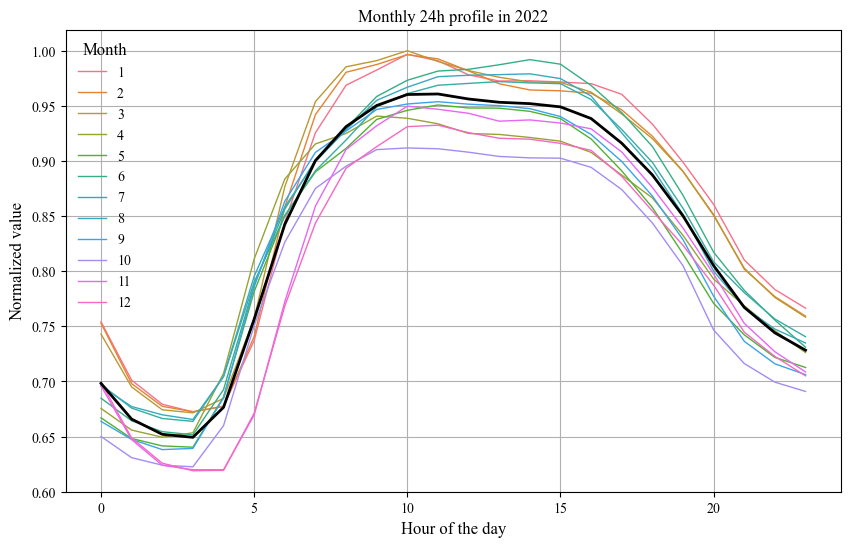

In [29]:
year = 2022
df_year= df[df['year'] == year]

monthly_24h_profile_year = df_year.groupby(['Month', 'Hour'])['Value_NE5'].mean().reset_index()
monthly_24h_profile_year['Value_NE5']=monthly_24h_profile_year['Value_NE5']/max(monthly_24h_profile_year['Value_NE5'])
monthly_24h_profile_pivot_year = monthly_24h_profile_year.pivot_table(
    index=['Hour'],
    columns='Month',
    values='Value_NE5')

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(1,13):
    plt.plot(monthly_24h_profile_pivot_year[i],label='Month',color=colors[i-1])
plt.plot(monthly_24h_profile_pivot_year.mean(axis=1), label='Mean', color='black', linewidth=2)
plt.xlabel('Hour of the day')
plt.ylabel('Normalized value')
plt.title(f'Monthly 24h profile in {year}')
plt.legend(monthly_24h_profile_pivot_year.columns, title='Month')
plt.grid()
plt.show()